In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('husl')
plt.style.context('ggplot')


from scipy import stats
import statsmodels.api as sm

from __future__ import division
import math

In [2]:
df_99 = pd.read_csv('Trial_99_Cleaned')
df_51 = pd.read_csv('Trial_051_Cleaned')

In [185]:
def cohensH (p1, p2):
    """calculates Cohen's h where it measures the distance between two proportions """
    phi1 = 2 * np.arcsin(np.sqrt(p1))
    phi2 = 2 * np.arcsin(np.sqrt(p2))
    h = phi1 - phi2
    print ('h = {}'.format(h))

def Ucrit (N1, N2):
    """calculates the UCRIT for comparison after the Mann-Whitney U test """
    mean = 0.5 * N1 * N2
    STD = np.sqrt(((N1 * N2) *((N1+N2) + 1))/12)
    UCRIT = mean - (1.96 * STD) - 0.5
    return UCRIT

def cliffsdelta (U, n1, n2):
    """calculates Cliff's Delta which measures how valus in one distribution are larger than the other """
    M = len(n1)
    N = len(n2)
    cdelta = (2 * U) / (M*N)
    print('Cliffs Delta = {}'.format(cdelta))

def manntest (df1, df2):
    """Calculates the U-statistic and p-value. Also compares U with Ucrit to test for signifance."""
    U,p = stats.mannwhitneyu(df1, df2, alternative='two-sided')
    print ('U = {}'.format(U))
    
    N1 = len(df1)
    N2 = len(df2)
    mean = 0.5 * N1 * N2
    STD = np.sqrt(((N1 * N2) *((N1+N2) + 1))/12)
    Z = (U-mean) / STD
    p_val = stats.norm.sf(abs(Z))*2 
    
    print ('pval = {}'. format(p_val))
    
    UCRIT = Ucrit(len(df1), len(df2))
    
    if U <= UCRIT:
        print ('Statistically Significant')
    else:
        print ('Not Statistically Significant')
    
    print ('UCRIT = {}'.format(UCRIT))

In [4]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

def prop_diff (data1, data2):
    """calculates the difference in proportions"""
    count_1 = len([values for values in data1 if values=='High'])

    total_1 = len(data1)
    
    count_2 = len([values for values in data2 if values=='High'])
    
    total_2 = len(data2)
    
    p1 = count_1 / total_1
    p2 = count_2 / total_2
    
    diff_prop = p1 - p2
    
    return diff_prop

def get_verduration (df, time):
    return df[df.Version_Duration==time]

def get_crosstab (df):
    return pd.crosstab(index=df['Overall_Exp_Rating'], columns=df['Version'], margins=True)

In [5]:
def twomeans (data1, data2, col1, col2):
    diff_means = data1[col1].mean() - data2[col2].mean()
    
    s1 = data1[col1].std()
    s2 = data2[col2].std()
    
    n1 = len(data1[col1])
    n2 = len(data2[col2])
    
    SEM  = np.sqrt(((s1**2)/n1) + ((s2**2)/n2))
    CI = diff_means - 1.96 * SEM, diff_means + 1.96 * SEM
    
    ttest = stats.ttest_ind(data1[col1], data2[col2])
    mw = stats.mannwhitneyu(data1[col1], data2[col2])
    
    print ('Mean Difference = {}'.format(diff_means)) 
    print ('CI = {}'.format(CI))
    print ('SEM = {}'.format(SEM))
    
    print ttest
    print mw

In [6]:
def twoporZtest (x1,x2, n1, n2):
    p1 = x1 / n1
    p2 = x2 / n2
    
    p_hat = (x1 + x2) / (n1 + n2)
    SEM = np.sqrt(p_hat* (1-p_hat) * ((1/n1) + (1/n2)))
    z = (p1-p2) / SEM
    p_val = stats.norm.sf(abs(z))
    diff_prop = p1-p2
    m = 1.96 * np.sqrt(  ((p1 * (1-p1))/n1)  +   ((p2 * (1-p2))/n2)    )
    CI = (diff_prop - m), (diff_prop + m)
    
    print ("z: {}".format(z))
    print ("p-value: {}".format(p_val))
    print ("CI: {}".format(CI))
    print ("proportion difference: {}".format(diff_prop))
    print ("p1: {}".format(p1))
    print ("p2: {}".format(p2))


In [7]:
def logodds(num1,num2,dem1,dem2):
    ODDS  = (num1/num2) / (dem1/dem2)
    logodds = np.log(ODDS)
    print ('log odds ratio = {}'.format(logodds))
    
def conttable(crosstab):
    """creates a contingency table and tests for independence among the categorical variables, then returns the 
    pearson r residuals. Also returns the pvalue of the ordinal association between the two """
    table = sm.stats.Table(crosstab)
    
    print ("Original Table")
    print (table.table_orig)
    print ("--------------")
    print ("Fitted Values")
    print(table.fittedvalues)
    print ("--------------")
    print ('Pearon Residuals')
    print(table.resid_pearson)
    result = table.test_ordinal_association()
    print ("--------------")
    print ("pvalue = {}".format(result.pvalue))
    
    


## Comparing Overall Experience Between the Two Trials



$H_o$: The proportion of users from trial 51 is higher than trial 99

In [8]:
df_99['Version'] = 'Version 99'
df_51['Version'] = 'Version 51'

In [9]:
# Version 51
pd.crosstab(index=df_51['Version_Duration'], columns=df_51['Overall_Experience'], margins=True)

Overall_Experience,Awful,Excellent,Good,No effect,Not good,All
Version_Duration,,,,,,
1 day,2,12,26,2,0,42
1 weeks,2,16,18,2,2,40
2 weeks,0,13,16,1,1,31
3 weeks,0,10,9,1,0,20
All,4,51,69,6,3,133


In [10]:
#trial 99
pd.crosstab(index=df_99['Version_Duration'], columns=df_99['Overall_Experience'], margins=True)

Overall_Experience,Awful,Excellent,Good,No effect,Not good,All
Version_Duration,,,,,,
1 day,0,9,29,1,0,39
1 weeks,1,9,16,1,3,30
2 weeks,0,7,11,1,1,20
3 weeks,0,3,8,2,0,13
All,1,28,64,5,4,102


In [11]:
t99 = df_99[['Overall_Experience','Version_Duration']]
t51 = df_51[['Overall_Experience', 'Version_Duration']]

In [12]:
ver_51 = pd.DataFrame(t51)

In [13]:
ver_51['Version'] = 'Version 51'

In [14]:
ver_99 = pd.DataFrame(t99)
ver_99['Version'] = 'Version 99'

In [15]:
a = pd.concat([ver_51, ver_99])

In [16]:
pd.crosstab( index=a['Version_Duration'], columns=[a['Version'],a['Overall_Experience']], margins=True)

Version            Version 51                                   Version 99  \
Overall_Experience      Awful Excellent Good No effect Not good      Awful   
Version_Duration                                                             
1 day                       2        12   26         2        0          0   
1 weeks                     2        16   18         2        2          1   
2 weeks                     0        13   16         1        1          0   
3 weeks                     0        10    9         1        0          0   
All                         4        51   69         6        3          1   

Version                                               All  
Overall_Experience Excellent Good No effect Not good       
Version_Duration                                           
1 day                      9   29         1        0   81  
1 weeks                    9   16         1        3   70  
2 weeks                    7   11         1        1   51  
3 weeks                    3    8         2        0   33  
All                       28   64         5        4  235

In [17]:
#mapping the Overall experience column by binary values of high or low rating given. 
rating = {'Excellent': 'High',
          'Good':'High',
          'No effect': 'Low',
          'Not good':'Low',
          'Awful': "Low"}

### Testing to see which trial version of users tend to give a higher or lower overall experience score

$\hat{p}_{1}$ = The proportion of Trial 99 Users that gave the Nootropic a high overall experience rating

$\hat{p}_{2}$ = The proportion of Trial 51 Users that gave the Nootropic a high overall experience rating


$H_o$: $\hat{p}_{1}$ = $\hat{p}_{2}$

$H_A$: $\hat{p}_{1}$ < $\hat{p}_{2}$

The overall experience between both trials were separated into its four survey collection periods at day 1, week 1, week 2, and week 3 making the samples within the two trial versions independent. Since the data is ordinal, the data was divided into binary variables where the "Excellent" and "Good" responses are considered to be a "High" rating. "No effect", "Not good", and "Awful" is categorizd as a "Low" rating for the user's overall experience. Proportions of high ratings across the four version durations were calculated and compared between the two trial versions using a difference in proportions to determine which one has higher ratings. 


### Day 1: 
97.43% of Trial 99 users (out of 39 ratings) gave the nootropic a high rating after using the drug for on day. 90.47% of Trial 51 users rated the version high. Because both of the samples have fewer number of failures following the CLT condition does not meet, the samples have to be simulated. Under the Randomization test, a total of 81 "cards" was divided up into 76 "high"s and 5 "lows". The 81 "cards" was then randomized and shuffled into the two trial groups consisting of size 39 for Trial 99 and size 42 for Trial 51. The observed proportion difference is 0.0695. From the simulated replicates, a p-value of 0.3579 was calcuated. Because the p-value is less than 0.05, the null hypothesis is not rejected and can conclude there is no statistical difference between the proportion of high overall experience ratings of the two trial versions on day 1. 

In [18]:
df_99['Overall_Exp_Rating']= df_99['Overall_Experience'].map(rating)

In [19]:
df_51['Overall_Exp_Rating'] = df_51['Overall_Experience'].map(rating)

In [20]:
#version 51
pd.crosstab(index=df_51['Version_Duration'], columns=df_51['Overall_Exp_Rating'], margins=True)

Overall_Exp_Rating,High,Low,All
Version_Duration,,,
1 day,38,4,42
1 weeks,34,6,40
2 weeks,29,2,31
3 weeks,19,1,20
All,120,13,133


In [21]:
#version 99
pd.crosstab(index=df_99['Version_Duration'], columns=df_99['Overall_Exp_Rating'], margins=True)

Overall_Exp_Rating,High,Low,All
Version_Duration,,,
1 day,38,1,39
1 weeks,25,5,30
2 weeks,18,2,20
3 weeks,11,2,13
All,92,10,102


In [22]:
a['Overall_Exp_Rating']= a['Overall_Experience'].map(rating)

In [23]:
day_1 = a[a.Version_Duration=='1 day']
pd.crosstab(index=day_1['Overall_Exp_Rating'], columns=day_1['Version'], margins=True)

Version,Version 51,Version 99,All
Overall_Exp_Rating,,,
High,38,38,76
Low,4,1,5
All,42,39,81


In [24]:
pd.crosstab(index=day_1['Overall_Exp_Rating'], columns=day_1['Version']).apply(lambda x: x/x.sum(), axis=0)

Version,Version 51,Version 99
Overall_Exp_Rating,,
High,0.904762,0.974359
Low,0.095238,0.025641


In [25]:
permuted_data = np.random.permutation(day_1['Overall_Exp_Rating'])

In [26]:
np.unique((np.random.permutation(day_1['Overall_Exp_Rating'])), return_counts=True)

(array(['High', 'Low'], dtype=object), array([76,  5]))

In [27]:
len(permuted_data[:len(day_1[day_1.Version=='Version 99'][['Version']])]) #version 99, group 1

39

In [28]:
len(permuted_data[len(day_1[day_1.Version=='Version 99'][['Version']]):]) #version 51, group 2

42

In [29]:
d99 = df_99[df_99.Version_Duration=='1 day']['Overall_Exp_Rating']
d51 = df_51[df_51.Version_Duration=='1 day']['Overall_Exp_Rating']

In [30]:
permutation_sample(d99, d51)

(array(['High', 'High', 'High', 'High', 'High', 'High', 'High', 'High',
        'High', 'High', 'High', 'Low', 'High', 'High', 'High', 'High',
        'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High',
        'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High',
        'High', 'High', 'High', 'High', 'High', 'High', 'High'], dtype=object),
 array(['High', 'High', 'High', 'High', 'High', 'Low', 'High', 'High',
        'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High',
        'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High',
        'High', 'Low', 'High', 'Low', 'High', 'High', 'High', 'High',
        'High', 'High', 'High', 'Low', 'High', 'High', 'High', 'High',
        'High', 'High'], dtype=object))

In [31]:
obs = prop_diff(d99, d51)
obs
# original data 

0.06959706959706957

In [32]:
reps = draw_perm_reps(d99, d51, prop_diff, size=1000)

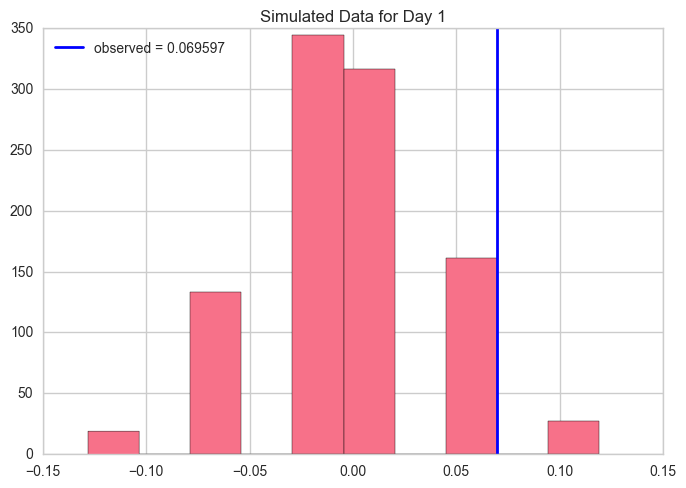

In [33]:
plt.hist(reps)

l = plt.axvline(obs,color='b', linewidth=2)
#ll = plt.axvline(-obs,color='b', linewidth=2)
plt.legend([l],['observed = {0:f}'.format(obs)], loc=2)

plt.title('Simulated Data for Day 1')


In [34]:
p = np.sum((reps) >= obs) / len(reps)
p

0.188

In [35]:
np.percentile(reps, [2.5, 97.5])

array([-0.07875458,  0.11904762])

In [36]:
df_overall_exp = pd.concat([t99,t51])
df_overall_exp['Overall_Exp_Rating'] = df_overall_exp['Overall_Experience'].map(rating)

In [37]:
#week 1

d99_week1 = df_99[df_99.Version_Duration=='1 weeks']['Overall_Exp_Rating']
d51_week1 = df_51[df_51.Version_Duration=='1 weeks']['Overall_Exp_Rating']


In [38]:
week1 = df_overall_exp[df_overall_exp.Version_Duration=='1 weeks']
pd.crosstab(index=week1['Overall_Exp_Rating'], columns=week1['Version'], margins=True)

Version,Version 51,Version 99,All
Overall_Exp_Rating,,,
High,34,25,59
Low,6,5,11
All,40,30,70


In [39]:
pd.crosstab(index=week1['Overall_Exp_Rating'], columns=week1['Version']).apply(lambda x: x/x.sum(), axis=0)

Version,Version 51,Version 99
Overall_Exp_Rating,,
High,0.85,0.833333
Low,0.15,0.166667


In [40]:
w1 = get_verduration(df_overall_exp, '1 weeks')

In [41]:
get_crosstab(w1)

Version,Version 51,Version 99,All
Overall_Exp_Rating,,,
High,34,25,59
Low,6,5,11
All,40,30,70


In [42]:
permutation_sample(d99_week1, d51_week1)

(array(['Low', 'High', 'High', 'Low', 'High', 'High', 'High', 'High',
        'High', 'High', 'Low', 'Low', 'High', 'High', 'Low', 'High', 'High',
        'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High',
        'High', 'High', 'High', 'High', 'High'], dtype=object),
 array(['High', 'High', 'High', 'Low', 'High', 'High', 'High', 'High',
        'Low', 'High', 'High', 'High', 'High', 'High', 'High', 'High',
        'High', 'High', 'High', 'High', 'High', 'High', 'Low', 'High',
        'High', 'High', 'High', 'High', 'High', 'High', 'Low', 'High',
        'Low', 'High', 'High', 'High', 'Low', 'High', 'High', 'High'], dtype=object))

In [43]:
obs_week1 = prop_diff(d99_week1, d51_week1)
obs_week1

-0.016666666666666607

In [44]:
reps_week1 = draw_perm_reps(d99_week1, d51_week1, prop_diff, size=1000)

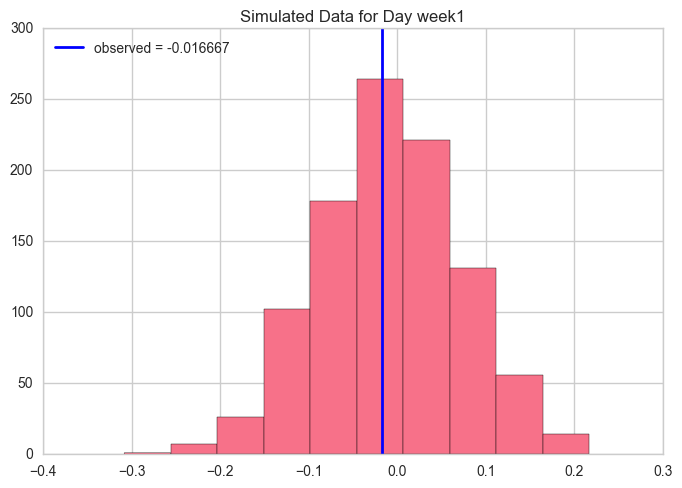

In [45]:
plt.hist(reps_week1)

l = plt.axvline(obs_week1,color='b', linewidth=2)
#ll = plt.axvline(-obs,color='b', linewidth=2)
plt.legend([l],['observed = {0:f}'.format(obs_week1)], loc=2)

plt.title('Simulated Data for Day week1')


In [46]:
np.sum((reps_week1) >= obs_week1) / len(reps_week1)

0.68600000000000005

In [47]:
#week 2

In [48]:
w2 = get_verduration(df_overall_exp, '2 weeks')
get_crosstab(w2)

Version,Version 51,Version 99,All
Overall_Exp_Rating,,,
High,29,18,47
Low,2,2,4
All,31,20,51


In [49]:
d99_week2 = df_99[df_99.Version_Duration=='2 weeks']['Overall_Exp_Rating']
d51_week2 = df_51[df_51.Version_Duration=='2 weeks']['Overall_Exp_Rating']

In [50]:
permutation_sample(d99_week2, d51_week2)

(array(['Low', 'High', 'Low', 'High', 'High', 'High', 'High', 'High',
        'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High',
        'High', 'High', 'High', 'Low'], dtype=object),
 array(['High', 'High', 'High', 'High', 'High', 'High', 'High', 'High',
        'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High',
        'High', 'High', 'High', 'High', 'High', 'Low', 'High', 'High',
        'High', 'High', 'High', 'High', 'High', 'High', 'High'], dtype=object))

In [51]:
obs_week2 = prop_diff(d99_week2, d51_week2)
obs_week2


-0.03548387096774186

In [52]:
reps_week2 = draw_perm_reps(d99_week2, d51_week2, prop_diff, size=1000)

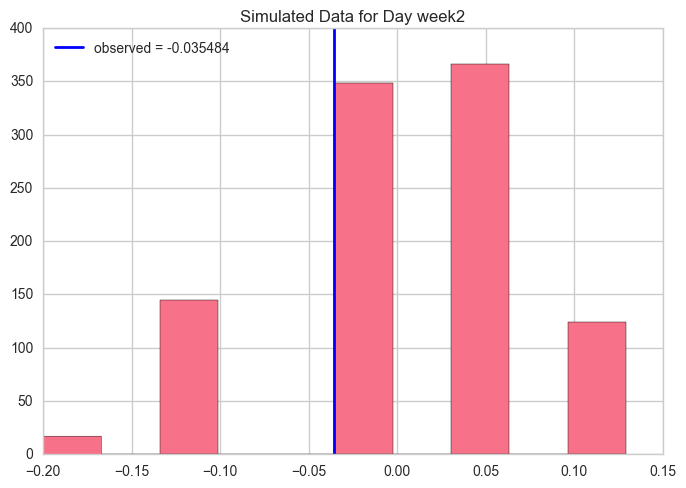

In [53]:
plt.hist(reps_week2)

l = plt.axvline(obs_week2,color='b', linewidth=2)
#ll = plt.axvline(-obs,color='b', linewidth=2)
plt.legend([l],['observed = {0:f}'.format(obs_week2)], loc=2)

plt.title('Simulated Data for Day week2')


In [54]:
np.sum((reps_week2) >= obs_week2) / len(reps_week2)

0.83799999999999997

In [55]:
#week 3

In [56]:
w3 = get_verduration(df_overall_exp, '3 weeks')
get_crosstab(w3)

Version,Version 51,Version 99,All
Overall_Exp_Rating,,,
High,19,11,30
Low,1,2,3
All,20,13,33


In [57]:
d99_week3 = df_99[df_99.Version_Duration=='3 weeks']['Overall_Exp_Rating']
d51_week3 = df_51[df_51.Version_Duration=='3 weeks']['Overall_Exp_Rating']

In [58]:
obs_week3 = prop_diff(d99_week3, d51_week3)
obs_week3


-0.10384615384615381

In [59]:
reps_week3 = draw_perm_reps(d99_week3, d51_week3, prop_diff, size=1000)

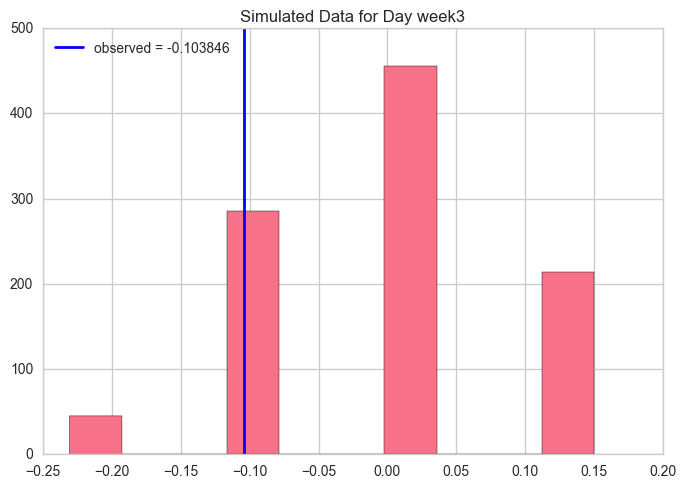

In [60]:
plt.hist(reps_week3)

l = plt.axvline(obs_week3,color='b', linewidth=2)
#ll = plt.axvline(-obs,color='b', linewidth=2)
plt.legend([l],['observed = {0:f}'.format(obs_week3)], loc=2)

plt.title('Simulated Data for Day week3')


In [61]:
np.sum((reps_week3) >= obs_week3) / len(reps_week3)

0.95499999999999996

In [62]:
#simulate all data without weekly restrictions

In [63]:
reps = draw_perm_reps(df_99['Overall_Exp_Rating'], df_51['Overall_Exp_Rating'], prop_diff, size=1000)

In [64]:
observed = prop_diff(df_99['Overall_Exp_Rating'], df_51['Overall_Exp_Rating'])
observed

-0.0002948547840188054

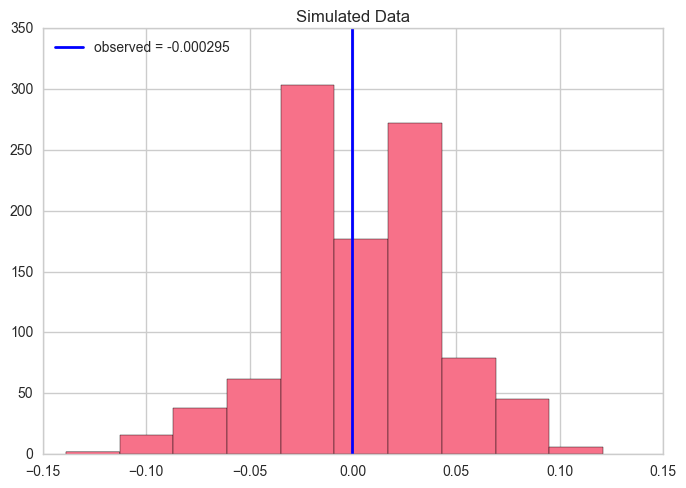

In [65]:
plt.hist(reps)

l = plt.axvline(observed,color='b', linewidth=2)
#ll = plt.axvline(-obs,color='b', linewidth=2)
plt.legend([l],['observed = {0:f}'.format(observed)], loc=2)

plt.title('Simulated Data')


In [66]:
np.sum((reps) >= observed) / len(reps)

0.57899999999999996

## Tracking the differences between Overall Experience score from day 1 to week 3


In [67]:
#changing the overall experience rating score into numeric number

exp_numeric_rating={'Excellent': 5, 'Good':4, 'No effect': 3, 'Not good': 4, 'Awful': 1}
df_99['Overall_Exp_Numeric'] = df_99['Overall_Experience'].map(exp_numeric_rating)

In [68]:
df_51['Overall_Exp_Numeric'] = df_51['Overall_Experience'].map(exp_numeric_rating)

In [69]:
stats.mannwhitneyu(df_99['Overall_Experience'], df_51['Overall_Experience'], alternative='two-sided')

MannwhitneyuResult(statistic=7717.0, pvalue=0.04080182361790962)

In [70]:
stats.mannwhitneyu(df_99['Overall_Exp_Numeric'], df_51['Overall_Exp_Numeric'], alternative='two-sided')

MannwhitneyuResult(statistic=6175.0, pvalue=0.17457538531248362)

In [71]:
stats.ttest_ind(df_99['Overall_Exp_Numeric'], df_51['Overall_Exp_Numeric'], equal_var=False)

Ttest_indResult(statistic=-0.56357365136352078, pvalue=0.5735863071518823)

In [72]:
diff_means = df_99['Overall_Exp_Numeric'].mean() - df_51['Overall_Exp_Numeric'].mean()
diff_means

-0.05204186937933031

In [73]:
s1 = df_99['Overall_Exp_Numeric'].std()
s2 = df_51['Overall_Exp_Numeric'].std()

n1 = len(df_99['Overall_Exp_Numeric'])
n2 = len(df_51['Overall_Exp_Numeric'])

In [74]:
SEM  = np.sqrt(((s1**2)/n1) + ((s2**2)/n2))

In [75]:
diff_means - 1.96 * SEM,diff_means + 1.96 * SEM

(-0.23303341101138084, 0.12894967225272022)

In [76]:
twomeans(df_99, df_51, 'Overall_Exp_Numeric', 'Overall_Exp_Numeric')

Mean Difference = -0.0520418693793
CI = (-0.23303341101138084, 0.12894967225272022)
SEM = 0.0923426232817
Ttest_indResult(statistic=-0.54445718897259732, pvalue=0.58664757576870363)
MannwhitneyuResult(statistic=6175.0, pvalue=0.087287692656241811)


In [186]:
manntest(df_99['Overall_Exp_Numeric'], df_51['Overall_Exp_Numeric']) # converted to ordinal scale 


U = 6175.0
pval = 0.239156747376
Not Statistically Significant
UCRIT = 5770.11114348


In [79]:
cliffsdelta(6175.0,df_99['Overall_Exp_Numeric'], df_51['Overall_Exp_Numeric']) # converted to 
#close to one, so there is some overlap

Cliffs Delta = 0.910364145658


In [80]:
7717/(133*102) #probabilistic effect size.

0.5688485920684063

In [81]:
cohensH((92/102), (120/133)) #cohen's h! less than 0.20

h = -0.000992215129706


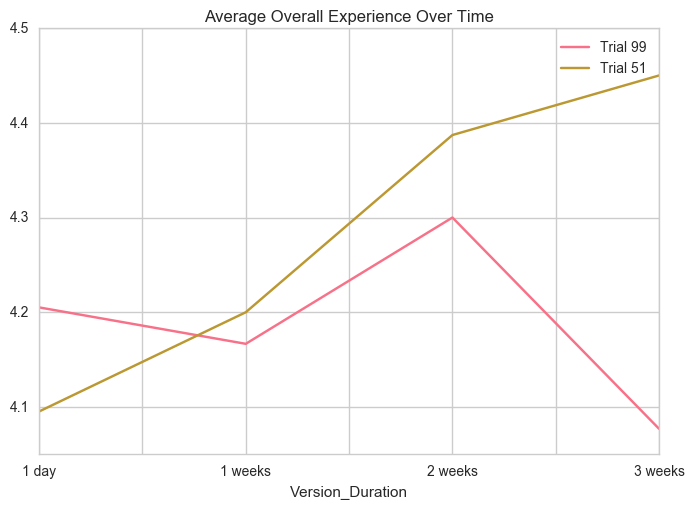

In [82]:
df_99.groupby(['Version_Duration'])['Overall_Exp_Numeric'].mean().plot()
df_51.groupby(['Version_Duration'])['Overall_Exp_Numeric'].mean().plot()
plt.legend(['Trial 99','Trial 51'])
plt.title('Average Overall Experience Over Time')

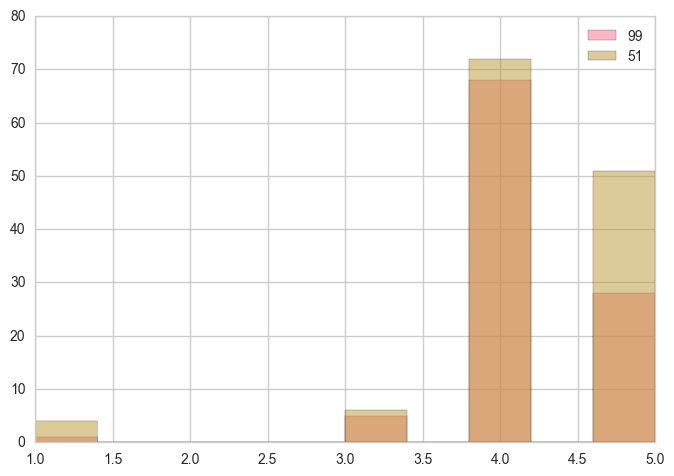

In [83]:
plt.hist(df_99['Overall_Exp_Numeric'], label='99', alpha=0.5)
plt.hist(df_51['Overall_Exp_Numeric'], label='51', alpha=0.5)
plt.legend()
plt.show()

In [84]:
pd.crosstab(index=df_overall_exp.Overall_Exp_Rating, columns=df_overall_exp.Version, margins=True)

Version,Version 51,Version 99,All
Overall_Exp_Rating,,,
High,120,92,212
Low,13,10,23
All,133,102,235


In [85]:
twoporZtest(92, 120, 102, 133)

z: -0.00753938927795
p-value: 0.496992247343
CI: (-0.076961232978621716, 0.076371523410584105)
proportion difference: -0.000294854784019
p1: 0.901960784314
p2: 0.902255639098


In [86]:
cont_table = pd.crosstab(index=df_overall_exp.Overall_Exp_Rating, columns=df_overall_exp.Version)
cont_table

Version,Version 51,Version 99
Overall_Exp_Rating,,
High,120,92
Low,13,10


In [87]:
stats.chi2_contingency(cont_table)

(0.04576611796223172,
 0.83060151197595922,
 1,
 array([[ 119.98297872,   92.01702128],
        [  13.01702128,    9.98297872]]))

In [88]:
stats.fisher_exact(cont_table) #if expected frequency is less than 5

(1.0033444816053512, 1.0)

In [89]:
numeric_map = {'Excellent': 5, 'Good': 4, 'No effect':3 ,'Not good':2, 'Awful':1}


# Sleep Quality

In [90]:
s99 = df_99[['Sleep_Quality','Overall_Exp_Rating', 'Version', 'Version_Duration']]
s51 = df_51[['Sleep_Quality','Overall_Exp_Rating', 'Version', 'Version_Duration']]
sleep_df = pd.concat([s99, s51])

In [91]:
sq = pd.crosstab(index=df_99.Overall_Exp_Rating, columns=df_99.Sleep_Quality, margins=True) # trial 99
sq

Sleep_Quality,Excellent,OK,Poor,All
Overall_Exp_Rating,,,,
High,46,40,4,90
Low,1,9,0,10
All,47,49,4,100


In [92]:
table = sm.stats.Table(sq)

In [93]:
print(table.table_orig)

Sleep_Quality       Excellent  OK  Poor  All
Overall_Exp_Rating                          
High                       46  40     4   90
Low                         1   9     0   10
All                        47  49     4  100


In [94]:
print(table.fittedvalues)

Sleep_Quality       Excellent         OK      Poor         All
Overall_Exp_Rating                                            
High                42.810345  44.603448  4.258621   90.327586
Low                  5.174877   5.391626  0.514778   10.918719
All                 47.514778  49.504926  4.726601  100.253695


In [95]:
print(table.resid_pearson)

Sleep_Quality       Excellent        OK      Poor       All
Overall_Exp_Rating                                         
High                 0.563912 -0.614419  0.116968  0.018141
Low                 -1.615447  1.769335 -0.020598 -0.126718
All                 -0.002144 -0.000700 -0.104229  0.024599


In [96]:
result = table.test_ordinal_association()
print (result.pvalue)

0.892530877743


In [97]:
sq51 = pd.crosstab(index=df_51.Overall_Exp_Rating, columns=df_51.Sleep_Quality)
table = sm.stats.Table(sq51)

print (table.table_orig)

Sleep_Quality       Excellent  OK  Poor
Overall_Exp_Rating                     
High                       46  64     9
Low                         1   8     4


In [98]:
print (table.fittedvalues)

Sleep_Quality       Excellent         OK       Poor
Overall_Exp_Rating                                 
High                42.371212  64.909091  11.719697
Low                  4.628788   7.090909   1.280303


In [99]:
print (table.resid_pearson)

Sleep_Quality       Excellent        OK      Poor
Overall_Exp_Rating                               
High                 0.557476 -0.112838 -0.794442
Low                 -1.686662  0.341394  2.403611


In [100]:
result = table.test_ordinal_association()
print (result.pvalue)

0.00302629111994


In [101]:
pd.crosstab(index=sleep_df.Sleep_Quality, columns=sleep_df.Version, margins=True)

Version,Version 51,Version 99,All
Sleep_Quality,,,
Excellent,47,47,94
OK,72,49,121
Poor,13,4,17
All,132,100,232


In [102]:
#excellent between the two
twoporZtest(47, 47, 100, 132)

z: 1.75065832401
p-value: 0.040002391143
CI: (-0.013505537747437207, 0.241384325626225)
proportion difference: 0.113939393939
p1: 0.47
p2: 0.356060606061


In [103]:
cohensH((47/100), (47/132))

h = 0.231975060439


In [104]:
#ok

twoporZtest(49, 72, 100, 132)

z: -0.837363320548
p-value: 0.201194188341
CI: (-0.18513023996920283, 0.074221149060111985)
proportion difference: -0.0554545454545
p1: 0.49
p2: 0.545454545455


In [105]:
#Poor
twoporZtest(4, 13, 100, 132)

z: -1.69289739432
p-value: 0.045237499703
CI: (-0.1221959457563685, 0.0052262487866715293)
proportion difference: -0.0584848484848
p1: 0.04
p2: 0.0984848484848


In [106]:
def prop_diff_exl (data1, data2):
    """calculates the difference in proportions"""
    count_1 = len([values for values in data1 if values=='Excellent'])

    total_1 = len(data1)
    
    count_2 = len([values for values in data2 if values=='Excellent'])
    
    total_2 = len(data2)
    
    p1 = count_1 / total_1
    p2 = count_2 / total_2
    
    diff_prop = p1 - p2
    
    return diff_prop

In [107]:
exl = {'Excellent':'Excellent','OK': 'Not Excellent', 'Poor': 'Not Excellent'}
ss99 = s99['Sleep_Quality'].map(exl)
ss51 = s51['Sleep_Quality'].map(exl)
sleep_reps = draw_perm_reps(ss99, ss51, prop_diff_exl ,size=1000)

In [108]:
excellent = prop_diff_exl(ss99, ss51)
excellent

0.10740085507887365

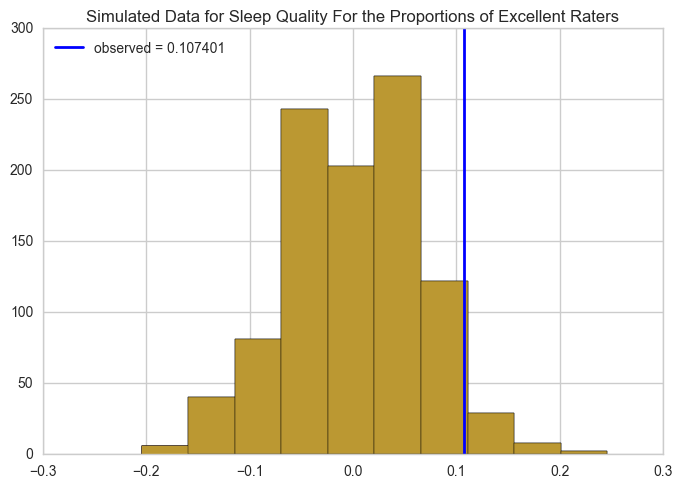

In [109]:
plt.hist(sleep_reps)


plt.hist(sleep_reps)

l = plt.axvline(excellent,color='b', linewidth=2)
#ll = plt.axvline(-obs,color='b', linewidth=2)
plt.legend([l],['observed = {0:f}'.format(excellent)], loc=2)

plt.title('Simulated Data for Sleep Quality For the Proportions of Excellent Raters')


In [110]:
np.sum((sleep_reps) >= excellent) / len(sleep_reps)

0.068000000000000005

In [111]:
sleep_rating = {'Excellent': 3, 'OK': 2, 'Poor': 1}
sleep_df['Sleep_Quality_Score'] = sleep_df['Sleep_Quality'].map(sleep_rating)

In [112]:
s = pd.crosstab(index=sleep_df.Version_Duration, columns=sleep_df.Version, values=sleep_df.Sleep_Quality_Score, aggfunc='mean')
s

Version,Version 51,Version 99
Version_Duration,,
1 day,2.170732,2.405405
1 weeks,2.275000,2.433333
2 weeks,2.322581,2.450000
3 weeks,2.300000,2.461538


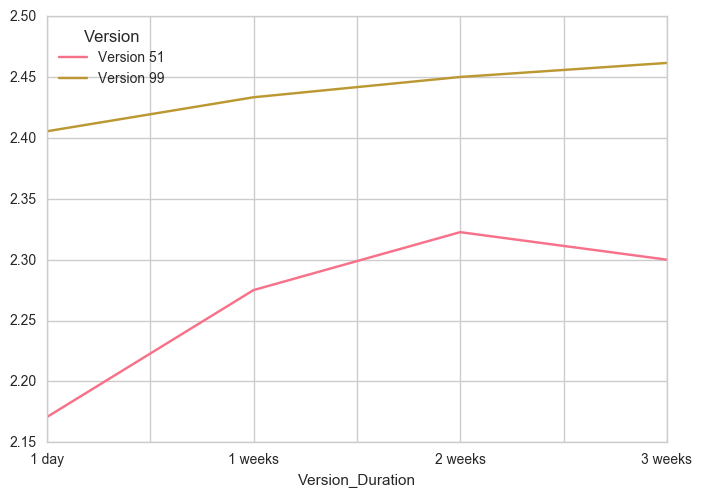

In [113]:
s.plot()

In [114]:
x = sleep_df[sleep_df.Version=='Version 99']['Sleep_Quality_Score'].dropna()
y = sleep_df[sleep_df.Version=='Version 51']['Sleep_Quality_Score'].dropna()

In [115]:
stats.ttest_ind(x,y, equal_var=False)

Ttest_indResult(statistic=2.1815022814071678, pvalue=0.030197167815845312)

In [116]:
stats.mannwhitneyu(x,y, alternative='two-sided')

MannwhitneyuResult(statistic=7526.5, pvalue=0.039754857558115302)

In [187]:
manntest(x,y)

U = 7526.5
pval = 0.0672373182999
Not Statistically Significant
UCRIT = 5607.22882739


In [118]:
cliffsdelta(5673.5, x,y) #no overlap

Cliffs Delta = 0.859621212121


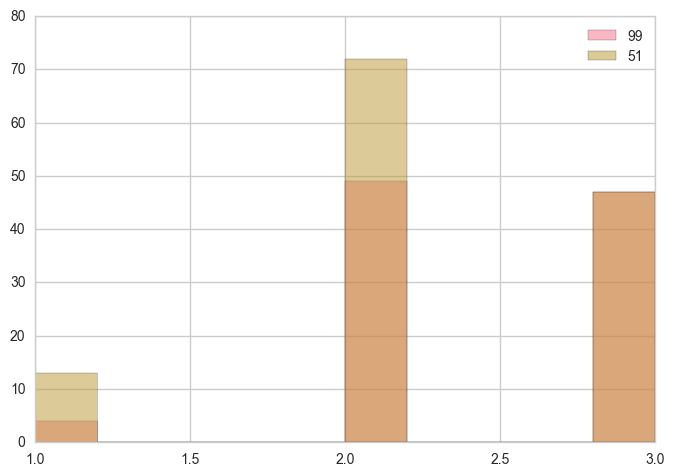

In [119]:
plt.hist(x, label='99', alpha=0.5)
plt.hist(y, label='51', alpha=0.5)
plt.legend()
plt.show()

## Focus Attention and Concentration

In [120]:
FAC99 = pd.crosstab(index=df_99.Overall_Exp_Rating, columns=df_99.Focus_Atten_Concen)
conttable(FAC99)

Original Table
Focus_Atten_Concen  Improved  Less good  No effect
Overall_Exp_Rating                                
High                      74          2         15
Low                        2          2          6
--------------
Fitted Values
Focus_Atten_Concen   Improved  Less good  No effect
Overall_Exp_Rating                                 
High                68.475248    3.60396  18.920792
Low                  7.524752    0.39604   2.079208
--------------
Pearon Residuals
Focus_Atten_Concen  Improved  Less good  No effect
Overall_Exp_Rating                                
High                0.667646  -0.844897  -0.901372
Low                -2.014034   2.548733   2.719098
--------------
pvalue = 0.000121544644596


In [121]:
logodds(74,2,17,8) # combine less good and no effect together

log odds ratio = 2.85714611027


In [122]:
FAC51 = pd.crosstab(index=df_51.Overall_Exp_Rating, columns=df_51.Focus_Atten_Concen)
conttable(FAC51)

Original Table
Focus_Atten_Concen  Improved  Less good  No effect
Overall_Exp_Rating                                
High                     111          0          8
Low                        1          5          7
--------------
Fitted Values
Focus_Atten_Concen    Improved  Less good  No effect
Overall_Exp_Rating                                  
High                100.862963   5.355556  14.281481
Low                  12.137037   0.644444   1.718519
--------------
Pearon Residuals
Focus_Atten_Concen  Improved  Less good  No effect
Overall_Exp_Rating                                
High                1.059144  -2.098151  -1.529863
Low                -3.053264   6.048479   4.410238
--------------
pvalue = 6.87791109383e-12


In [123]:
logodds(111,1, 8, 12)

log odds ratio = 5.11499530942


In [124]:
f99 = df_99[['Focus_Atten_Concen','Overall_Exp_Rating', 'Version', 'Version_Duration']]
f51 = df_51[['Focus_Atten_Concen','Overall_Exp_Rating', 'Version', 'Version_Duration']]
f_df = pd.concat([f99, f51])

In [125]:
pd.crosstab(index=f_df.Focus_Atten_Concen, columns=f_df.Version, margins=True)

Version,Version 51,Version 99,All
Focus_Atten_Concen,,,
Improved,112,76,188
Less good,5,4,9
No effect,15,21,36
All,132,101,233


In [126]:
#improved
twoporZtest(76, 112, 101, 132)

z: -1.83973426074
p-value: 0.0329036305005
CI: (-0.20005676678369366, 0.0080375648635015867)
proportion difference: -0.0960096009601
p1: 0.752475247525
p2: 0.848484848485


In [127]:
cohensH((76/101), (112/132))

h = -0.241838388469


In [128]:
#less good
twoporZtest(4, 5, 101, 132)

z: 0.0677193654747
p-value: 0.473004516639
CI: (-0.048348120008156407, 0.051798465042659857)
proportion difference: 0.00172517251725
p1: 0.039603960396
p2: 0.0378787878788


In [129]:
#no effect
#less good
twoporZtest(21, 15, 101, 132)

z: 1.97324595969
p-value: 0.0242337732617
CI: (-0.0016083696115250928, 0.19017722649721364)
proportion difference: 0.0942844284428
p1: 0.207920792079
p2: 0.113636363636


In [130]:
rating_3 = {'Improved':3, 'Less good':2, 'No effect':1}

In [131]:
f_df['FAC_Rating'] = f_df['Focus_Atten_Concen'].map(rating_3)

f_df99 = f_df[f_df.Version=='Version 99']['FAC_Rating'].dropna()
f_df51 = f_df[f_df.Version=='Version 51']['FAC_Rating'].dropna()


In [132]:
stats.mannwhitneyu(f_df99, f_df51, alternative='two-sided')

MannwhitneyuResult(statistic=6003.5, pvalue=0.058503882463414224)

In [180]:
Ucrit1(f_df99, f_df51, 6003.5)

pval = 0.193829206224


In [177]:
stats.mannwhitneyu(f_df99, f_df51, alternative='two-sided', use_continuity=False)

MannwhitneyuResult(statistic=6003.5, pvalue=0.058313718015346579)

In [134]:
manntest(f_df99, f_df51)

U = 6003.5
p-val = 0.0585038824634
Not Statistically Significant
UCRIT = 5666.14214698


In [135]:
cliffsdelta(7430,df_99['Focus_Atten_Concen'], df_51['Focus_Atten_Concen'] ) 

Cliffs Delta = 1.09538552263


In [136]:
pd.crosstab(index=f_df.Version_Duration, columns=f_df.Version, values=f_df.FAC_Rating, aggfunc=np.mean)

Version,Version 51,Version 99
Version_Duration,,
1 day,2.658537,2.526316
1 weeks,2.725000,2.533333
2 weeks,2.870968,2.600000
3 weeks,2.700000,2.538462


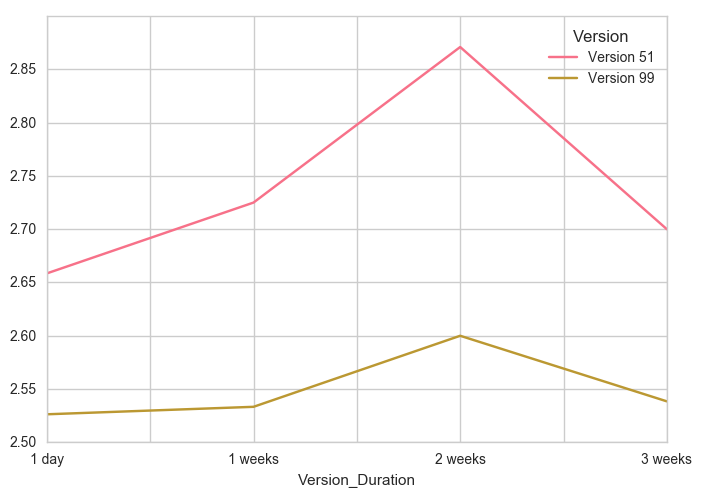

In [137]:
pd.crosstab(index=f_df.Version_Duration, columns=f_df.Version, values=f_df.FAC_Rating, aggfunc=np.mean).plot()

In [138]:
stats.ttest_ind(f_df[f_df.Version=='Version 99']['FAC_Rating'].dropna(), f_df[f_df.Version=='Version 51']['FAC_Rating'].dropna(), equal_var=False)

Ttest_indResult(statistic=-1.916320121376307, pvalue=0.056849328234860476)

In [139]:
f_df.groupby(['Version'])['FAC_Rating'].std()

Version
Version 51    0.652182
Version 99    0.818838
Name: FAC_Rating, dtype: float64

In [140]:
f_df.groupby(['Version'])['FAC_Rating'].median()

Version
Version 51    3.0
Version 99    3.0
Name: FAC_Rating, dtype: float64

## Memory

In [141]:
MEM99 = pd.crosstab(index=df_99.Overall_Exp_Rating, columns=df_99.Memory)
conttable(MEM99)

Original Table
Memory              Improved  Less good  No effect
Overall_Exp_Rating                                
High                      29          2         60
Low                        1          0          9
--------------
Fitted Values
Memory               Improved  Less good  No effect
Overall_Exp_Rating                                 
High                27.572115   2.668269  62.259615
Low                  3.427885   0.331731   7.740385
--------------
Pearon Residuals
Memory              Improved  Less good  No effect
Overall_Exp_Rating                                
High                0.367152  -0.103012  -0.223005
Low                -1.041281   0.292154   0.632465
--------------
pvalue = 0.208001260759


In [142]:
logodds(29, 1, 62, 9)

log odds ratio = 1.43738602228


In [143]:
MEM51 = pd.crosstab(index=df_51.Overall_Exp_Rating, columns=df_51.Memory)
conttable(MEM51)

Original Table
Memory              Improved  Less good  No effect
Overall_Exp_Rating                                
High                      73          1         45
Low                        1          2         10
--------------
Fitted Values
Memory               Improved  Less good  No effect
Overall_Exp_Rating                                 
High                66.712121   2.704545  49.583333
Low                  7.287879   0.295455   5.416667
--------------
Pearon Residuals
Memory              Improved  Less good  No effect
Overall_Exp_Rating                                
High                0.769842  -1.036481  -0.650899
Low                -2.329183   3.135908   1.969316
--------------
pvalue = 0.00121835204388


In [144]:
logodds (73, 1, 46, 12)

log odds ratio = 2.94672469445


In [145]:
m99 = df_99[['Memory','Overall_Exp_Rating', 'Version', 'Version_Duration']]
m51 = df_51[['Memory','Overall_Exp_Rating', 'Version', 'Version_Duration']]
m_df = pd.concat([m99, m51])

In [146]:
pd.crosstab(index=m_df.Memory, columns=m_df.Version, margins=True)

Version,Version 51,Version 99,All
Memory,,,
Improved,74,30,104
Less good,3,2,5
No effect,55,69,124
All,132,101,233


In [147]:
#improved
twoporZtest(30, 101, 74, 132)

z: -5.14832864411
p-value: 1.31408861727e-07
CI: (-0.49295087194869325, -0.2265413475435262)
proportion difference: -0.359746109746
p1: 0.405405405405
p2: 0.765151515152


In [148]:
#less good
twoporZtest(2, 101, 3, 132)

z: -0.396634326067
p-value: 0.345818567969
CI: (-0.63680874959462863, 0.43983905262493161)
proportion difference: -0.0984848484848
p1: 0.666666666667
p2: 0.765151515152


In [149]:
#no effect
twoporZtest(69, 55, 101, 132) # significant 

z: 4.0401866006
p-value: 2.67043453336e-05
CI: (0.14278243501003396, 0.39022086531999911)
proportion difference: 0.266501650165
p1: 0.683168316832
p2: 0.416666666667


In [150]:
manntest(df_99['Memory'], df_51['Memory'])

U = 8573.0
p-val = 7.57741608714e-05
Not Statistically Significant
UCRIT = 5770.11114348


/Users/macbook/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:5379: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  obs = np.r_[True, arr[1:] != arr[:-1]]


In [151]:
cliffsdelta(8573,df_99['Memory'], df_51['Memory'])

Cliffs Delta = 1.2638950317


In [152]:
m_df['Memory_Rating'] = m_df['Memory'].map(rating_3)

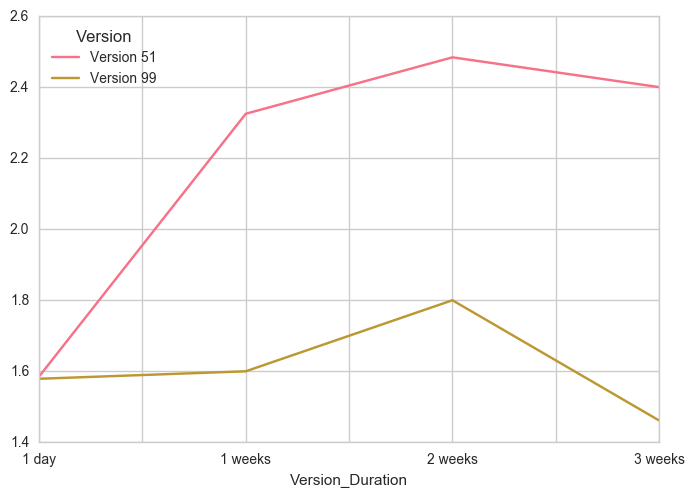

In [153]:
pd.crosstab(index=m_df.Version_Duration, columns=m_df.Version, values=m_df.Memory_Rating, aggfunc=np.mean).plot()

In [154]:
manntest(df_99[])

SyntaxError: invalid syntax (<ipython-input-154-d888771911eb>, line 1)

## Finding the duration effect of the Nootropic for both trials

In [ ]:
df_99.Upper_Effect_Duration.median()

In [ ]:
df_99.Lower_Effect_Duration.median()

In [ ]:
df_51.Upper_Effect_Duration.median()

In [ ]:
df_51.Lower_Effect_Duration.median()

In [ ]:
stats.mannwhitneyu(df_99.Upper_Effect_Duration, df_51.Upper_Effect_Duration, alternative='two-sided')

In [ ]:
stats.mannwhitneyu(df_99.Lower_Effect_Duration, df_51.Lower_Effect_Duration, alternative='two-sided')

In [ ]:
len(df_51.Upper_Effect_Duration)